In [415]:
#Data import using Numpy

import numpy as np
import csv
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm


__Load Data File__

We are using csv reader to load data file to our numpy array

In [ ]:
data_dir = "data/"
file_name = data_dir + "BasicDefaultTypeEMG.csv"

reader = csv.reader(open(file_name, "rb"), delimiter=",")
x = list(reader)
result = np.array(x[1:])

__Extract Imp Featurs__

From the loaded data, we are extracting main features that is emg pods value which is collected from myo arm band device, this will be feeded in the neural network. We extract the target value from the file and store it in the grips_data.


In [174]:
#Number of rows that is going to be processed
#Number of each defined for each classificatinon
print result.shape
emg_pods = result[33142:,1:9].astype('float64')
grips_data = result[33142:,-1]
grips_type = np.unique(grips_data)


for grip in grips_type:
    print("%s  Rows  are %d" % (grip, len(grips_data[grips_data ==grip])))


(120133, 19)
The Continental Grip  (Bevel #2)  Rows  are 21243
The Eastern Forehand Grip (Bevel #3)  Rows  are 18314
The Semi-Western Forehand Grip (Bevel #3)  Rows  are 22999
The Western Forehand Grip (Bevel #5)  Rows  are 24435


__Feature Scaling__

We are normalizing our data using standard scaler, we should try different scaler to find out the result

In [ ]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(emg_pods)
emg_pods =  scaled_data


__Analyzing the data__

We are taking standard deviation and mean of the emg pods, using this value we are ploting a normal distribution graphs. 

We are also using scatter to plot to define a correlation between pod values and grip types.



In [ ]:

grip_count = 4
figs, axs = plt.subplots(nrows=grip_count, ncols=1, figsize=(18,40))
s_fig, s_axs = plt.subplots(nrows=4, ncols=1, figsize=(18,40)) 

for type_id in range(grip_count):

    random_select = random.sample(range(15000), 30)
    t = emg_pods[grips_data == grips_type[type_id]] #semi western
    #y = (np.random.rand(len(random_select), 1) + type_id)
    #sd = np.std(t, axis=0)
    mean = np.mean(t, axis=0)
    #color=next(colors)
    colors = iter(cm.rainbow(np.linspace(0, 1, 8)))

    # Mean = 0, SD = 2.
    for i in range(8):
        s_axs[type_id].scatter(t[random_select,i], y, color=next(colors))
        s_axs[type_id].plot(mean[i].repeat(30), y)
        x_axis = np.arange(np.min(t[:,i]), np.max(t[:,i]), 1)
        axs[type_id].plot(x_axis, norm.pdf(x_axis,mean[i], 2), label = "pod" + str(i))
        s_axs[type_id].set_title("Grip Type %s" % grips_type[type_id])
        

    axs[type_id].legend('12345678',shadow=True, fancybox=True, loc="upper right");
    axs[type_id].set_title(grips_type[type_id] )


__Label Classifiers__

We are using one hot encoding, for the grip types coloumn

Working => 

grips_data["conti.", "western", etc]

then resultant vector would

[[1,0,0,0], [0,0,0,1],..etc] 

In [280]:
#Data Preprossing
#removing extra coloumns
# onehot encoding - label classifier

from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(grips_data)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y_labels = onehot_encoder.fit_transform(integer_encoded)


#prepare training-set, test-set, valid-set.


__Preparing Data Set__

We are using train test split, to create a Training and Test data.
Also we are using half of the test data as validation data set which
well help us check how out model is performing on the go

In [418]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(emg_pods, Y_labels,  test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)
print X_train.shape
print X_test.shape
print X_val.shape
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

(60893, 8)
(13049, 8)
(13049, 8)


In [357]:
#Create MultiLayer Perceptron Network


from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.models import Sequential


model = Sequential()
model.add(Dense(16, input_shape=(8,), activation = 'relu', kernel_initializer='truncated_normal'))
model.add(Dense(len(grips_type), activation='softmax', kernel_initializer='truncated_normal'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 68        
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________


In [436]:
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, LeakyReLU
from keras.models import Sequential
model = Sequential()

model.add(Conv1D(32, 1, activation='relu', input_shape=(8,1)))
model.add(Conv1D(64, 1, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(128, 2, activation='relu', ))
model.add(Conv1D(128, 2, activation='relu', ))
model.add(Dropout(.4))
model.add(Conv1D(256, 3, activation='relu', ))
model.add(Conv1D(256, 3, activation='relu', ))
model.add(Dropout(.4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(len(grips_type), activation='softmax', kernel_initializer='truncated_normal'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_116 (Conv1D)          (None, 8, 32)             64        
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 8, 64)             2112      
_________________________________________________________________
dropout_76 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_118 (Conv1D)          (None, 7, 128)            16512     
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 6, 128)            32896     
_________________________________________________________________
dropout_77 (Dropout)         (None, 6, 128)            0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 4, 256)            98560     
__________

In [437]:
#Test MultiLayer Network
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print X_train.shape

(60893, 8, 1)


In [ ]:

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),verbose=1)

Train on 60893 samples, validate on 13049 samples
Epoch 1/20
60893/60893 [==============================] - 26s 426us/step - loss: 1.3809 - acc: 0.2821 - val_loss: 1.3826 - val_acc: 0.2731
Epoch 2/20
60893/60893 [==============================] - 24s 390us/step - loss: 1.3806 - acc: 0.2827 - val_loss: 1.3825 - val_acc: 0.2731
Epoch 3/20
60893/60893 [==============================] - 24s 386us/step - loss: 1.3805 - acc: 0.2827 - val_loss: 1.3829 - val_acc: 0.2731
Epoch 4/20
60893/60893 [==============================] - 24s 391us/step - loss: 1.3805 - acc: 0.2827 - val_loss: 1.3825 - val_acc: 0.2731
Epoch 5/20
60893/60893 [==============================] - 23s 378us/step - loss: 1.3805 - acc: 0.2827 - val_loss: 1.3827 - val_acc: 0.2731
Epoch 6/20
60893/60893 [==============================] - 23s 378us/step - loss: 1.3805 - acc: 0.2827 - val_loss: 1.3825 - val_acc: 0.2731
Epoch 7/20
60893/60893 [==============================] - 24s 393us/step - loss: 1.3805 - acc: 0.2827 - val_loss: 1.

In [399]:


model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, axis=0))) for test_vector in X_test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model_prediction)==np.argmax(y_test, axis=1))/len(model_prediction)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.0000%


In [192]:
print model_prediction[1:100]

[3, 2, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 2, 1, 1, 3, 0, 2, 2, 1, 3, 3, 0, 3, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 1, 3, 3, 3, 2, 3, 3, 2, 1, 1, 3, 2, 3, 1, 2, 2, 3, 0, 3, 3, 3, 3, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2]


In [193]:
print("shafo")

shafo


[[ 2  1  1  1]
 [ 5  9  5  6]
 [ 7  5 17  3]
 [ 9  7  6 15]]
Normalized confusion matrix
[[0.4  0.2  0.2  0.2 ]
 [0.2  0.36 0.2  0.24]
 [0.22 0.16 0.53 0.09]
 [0.24 0.19 0.16 0.41]]
Normalized confusion matrix


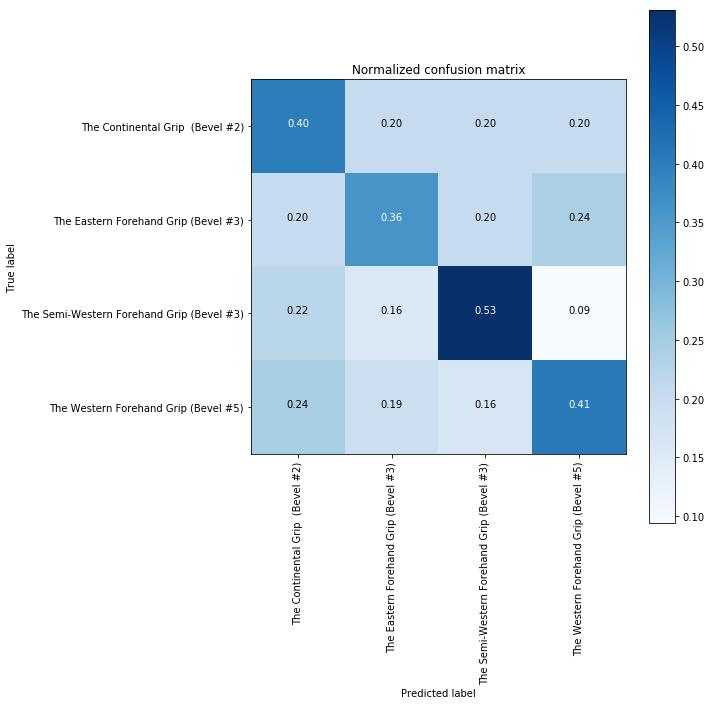

In [401]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix


## we need a better way analyse the confusion matrix for 133 labels.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
test_targets_result = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(model_prediction[1:100], test_targets_result[1:100])
np.set_printoptions(precision=2)
print cnf_matrix

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix")
print cm
# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=grip_types,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=grips_type, normalize=True,
                      title='Normalized confusion matrix')

#plt.show()

In [407]:
##testing live data 


from collections import Counter
def read_emg_from_file(file_name):
    reader = csv.reader(open(file_name, "rb"), delimiter=",")
    data = list(reader)
    data_set = np.array(x[1:])[:,1:9].astype('float64')
    return data_set
    

def detect_grip(filename):
    predict_data_set =  read_emg_from_file(file_name)
    predict_data_set = np.expand_dims(predict_data_set, axis=2)
    model_prediction = [np.argmax( model.predict(np.expand_dims(test_vector, axis=0))) for test_vector in emg_pods_test]
    counter = Counter(model_prediction).most_common(4)
    return grips_type[counter[0][0]]
    


In [408]:
file_name = data_dir + "test_continental.csv"
print detect_grip(file_name)

The Eastern Forehand Grip (Bevel #3)


In [387]:
##testing live data 
file_name = data_dir + "test_semiwesternfore.csv"


reader = csv.reader(open(file_name, "rb"), delimiter=",")
x = list(reader)
emg_pods_test = np.array(x[1:])[:,1:9].astype('float32')
emg_pods_test = np.expand_dims(emg_pods_test, axis=2)
new_model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, axis=0))) for test_vector in emg_pods_test]
print new_model_prediction
from collections import Counter
counter = Counter(new_model_prediction).most_common(5)
print (counter)
print(grips_type[counter[0][0]])


[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 3, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 3, 3, 0, 1, 1, 3, 1, 1, 0, 3, 0, 1, 2, 0, 2, 0, 3, 1, 3, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 3, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 3, 0, 3, 1, 3, 1, 0, 3, 1, 1, 1, 1, 1, 0, 3, 0, 1, 0, 1, 0, 1, 1, 0, 0, 3, 0, 3, 3, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 3, 1, 3, 0, 1, 1, 0, 0, 0, 1, 3, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 3, 0, 3, 1, 0, 1, 3, 0, 0, 0, 3, 0, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 2, 0, 0, 3, 1, 0, 1, 1, 1, 2, 1, 0, 1, 3, 0, 1, 1, 0, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 1, 0, 0, 3, 1, 3, 3, 0, 1, 1, 0, 3, 3, 1, 3, 1, 0, 1, 1, 0, 0, 1, 3, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 0, 1, 0, 3, 3, 0, 0, 0, 3, 2, 0, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 1, 0, 0, 3, 1, 3, 1, 0, 1, 1, 0, 1, 3, 0, 1, 1, 0, 3, 2, 0, 1, 1, 1, 0, 3, 0, 1, 3, 1, 0, 0, 1, 0, 3, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 3, 0, 3, 1, 1, 1, 3, 

In [388]:


##testing live data 
file_name = data_dir + "test_eastfore.csv"


reader = csv.reader(open(file_name, "rb"), delimiter=",")
x = list(reader)
emg_pods_test = np.array(x[1:])[:,1:9].astype('float32')
emg_pods_test = np.expand_dims(emg_pods_test, axis=2)
new_model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, axis=0))) for test_vector in emg_pods_test]
print new_model_prediction
from collections import Counter
counter = Counter(new_model_prediction).most_common(5)
print (counter)
print(grips_type[counter[0][0]])





[1, 1, 3, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0, 3, 0, 2, 0, 1, 0, 0, 1, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 3, 0, 1, 3, 0, 1, 1, 2, 1, 0, 3, 1, 1, 1, 0, 0, 0, 1, 3, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 0, 1, 2, 3, 0, 0, 1, 1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 0, 3, 1, 0, 1, 3, 1, 3, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 3, 1, 1, 1, 3, 1, 2, 1, 1, 3, 1, 1, 0, 0, 3, 1, 1, 1, 3, 3, 0, 3, 1, 1, 0, 0, 0, 0, 3, 1, 1, 1, 1, 3, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 3, 0, 0, 1, 3, 3, 2, 3, 1, 1, 0, 2, 3, 0, 3, 1, 0, 2, 1, 0, 1, 0, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 0, 0, 3, 1, 0, 0, 1, 0, 3, 3, 1, 0, 3, 0, 0, 3, 1, 1, 1, 0, 1, 0, 2, 1, 0, 2, 0, 0, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 0, 1, 1, 3, 

In [389]:

##testing live data 
file_name = data_dir + "test_westernfore.csv"


reader = csv.reader(open(file_name, "rb"), delimiter=",")
x = list(reader)
emg_pods_test = np.array(x[1:])[:,1:9].astype('float32')
emg_pods_test = np.expand_dims(emg_pods_test, axis=2)
new_model_prediction = [np.argmax(model.predict(np.expand_dims(test_vector, axis=0))) for test_vector in emg_pods_test]
print new_model_prediction
from collections import Counter
counter = Counter(new_model_prediction).most_common(5)
print (counter)
print(grips_type[counter[0][0]])

[1, 3, 3, 3, 1, 0, 1, 1, 3, 0, 1, 1, 1, 1, 0, 0, 0, 1, 3, 0, 1, 0, 1, 3, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 3, 1, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 0, 3, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 3, 1, 1, 0, 0, 1, 0, 1, 3, 3, 3, 3, 1, 0, 1, 1, 0, 0, 1, 0, 3, 3, 1, 3, 0, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 0, 0, 3, 0, 1, 1, 1, 3, 1, 1, 3, 0, 1, 0, 1, 3, 2, 1, 1, 1, 1, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 2, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 1, 0, 3, 1, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 0, 1, 0, 3, 2, 0, 1, 0, 0, 3, 1, 2, 3, 0, 1, 1, 1, 0, 1, 3, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 3, 1, 3, 3, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 3, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 